Explanation:  

In this project, I implemented a CNN model to classify the noist MNIST dataset. To prevent the model from overfitting the noises in the images, I added the dropout layers after convolutional layers. To help model learn to recognize the true features of various numbers, I augmented the data by adding the original clean images to the given training dataset. The original given training data was splitted into training and validation dataset in 9:1 splitting ratio.

After tuning the hyperparameters using the validation set, the model was then retrained on the entire training dataset. The trained model was then saved and submitted for testing set.


To load the trained model for testing on the withheld testing data, please reshape and rescale the testing tensor first. (Please See code/instructions at the end section.)



In [ ]:
!nvidia-smi

Wed Apr 13 03:15:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##### Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/'

/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning


#### Load data and preprocess

In [ ]:
import pickle
import numpy as np

train_images = pickle.load(open('636_project1_train_images', 'rb'))
train_labels = pickle.load(open('636_project1_train_labels', 'rb'))

# check dimension
print(type(train_images))
print(train_images.shape)
print(type(train_labels))
print(train_labels.shape)

print(np.amax(train_images[:,:]))

# reshape and normalize the image tensors
train_images = np.array(train_images).reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255.
train_labels = np.array(train_labels)

print(type(train_images))
print(train_images.shape)
print(type(train_labels))
print(train_labels.shape)
print(np.amax(train_images[:,:]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
(60000, 28, 28)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(60000,)
255
<class 'numpy.ndarray'>
(60000, 28, 28, 1)
<class 'numpy.ndarray'>
(60000,)
1.0


Here we plot the sampled training images, tried to use a median filter / thresholding to smooth the noise. But none of these helped the training.

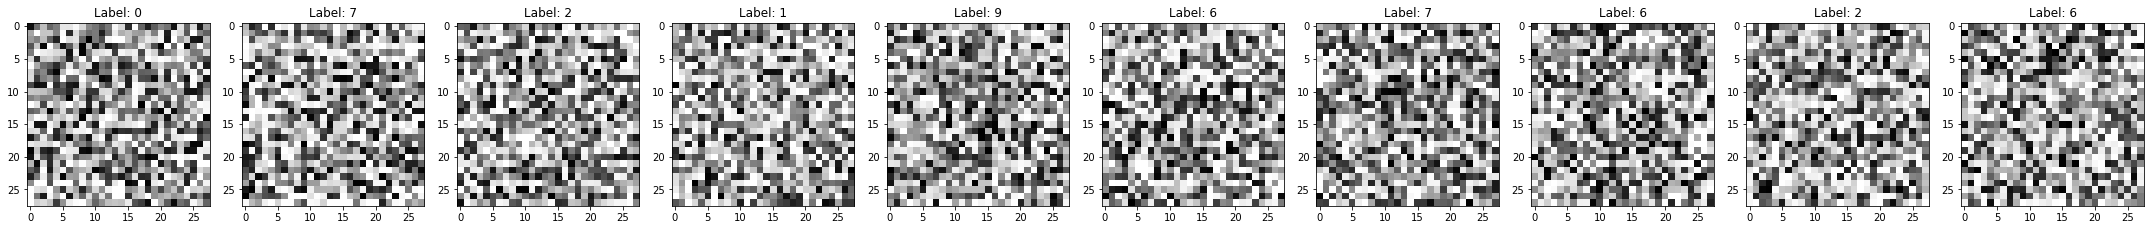

100%|██████████| 10/10 [00:00<00:00, 700.52it/s]


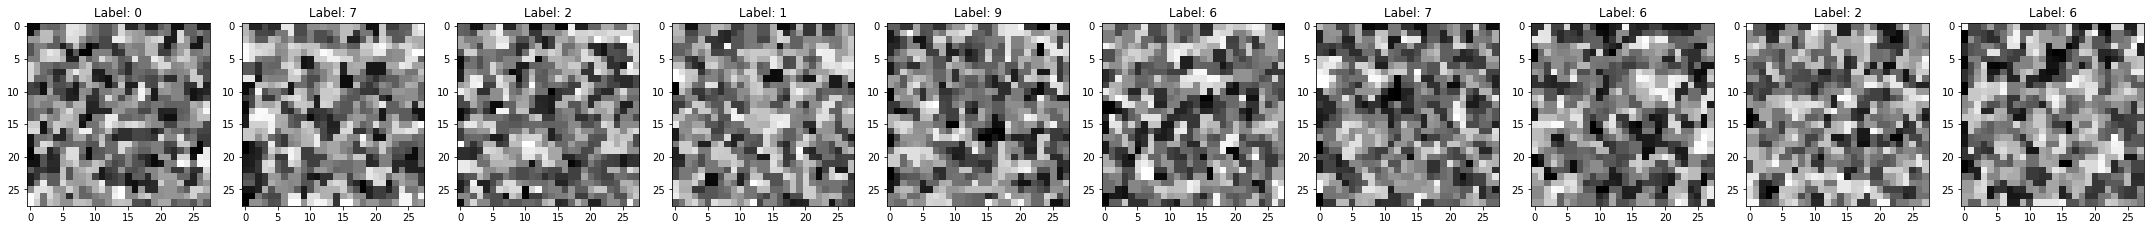

In [ ]:
# plot sample images

from scipy import ndimage
import cv2
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm

def filter_image(sample):

  result = ndimage.median_filter(sample, size=2) # hurt the original pixels
  # result = cv2.medianBlur(sample, 3)
  # result = cv2.GaussianBlur(sample, (3,3), 0)
  # result = sample

  # dim1, dim2 = sample.shape[:2]
  # result = np.zeros((dim1,dim2))
  # for i in range(dim1):
  #   for j in range(dim2):
  #     if sample[i,j] > 0.1:
  #       result[i,j] = sample[i,j]

  return result

num_sample = 10
idx = [random.randint(0, train_images.shape[0]) for i in range(num_sample)]

# plot original noisy images
fig, axes = plt.subplots(1, 10)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = train_images[idx[i], :].reshape(28, 28)
  im = axes[i].imshow(sample_img, cmap='Greys') #vmax=0.5
  axes[i].set_title('Label: {}'.format(train_labels[idx[i]]))

# fig.colorbar(im, ax=axes[num_sample-1])
plt.tight_layout()
plt.show()

# plot images after median filter
fig, axes = plt.subplots(1, 10)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in tqdm(range(num_sample)):
  sample_img = train_images[idx[i], :]
  sample_img = filter_image(sample_img)
  axes[i].imshow(sample_img.reshape(28,28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(train_labels[idx[i]]))

plt.tight_layout()
plt.show()

#### Split given data into train and val set

In [ ]:
# split into train and val dataset

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(54000, 28, 28, 1)
(54000,)
(6000, 28, 28, 1)
(6000,)


Add original MNIST train and test data to the training dataset to help the model learn better

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images_clean, train_labels_clean), (test_images_clean, test_labels_clean) = mnist.load_data()
train_images_clean = train_images_clean.reshape((60000, 28, 28, 1))
train_images_clean = train_images_clean.astype("float32") / 255
test_images_clean = test_images_clean.reshape((10000, 28, 28, 1))
test_images_clean = test_images_clean.astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# concatenate the noisy train data with the original train and test data
X_train_agg = np.vstack([X_train, train_images_clean, test_images_clean])
y_train_agg = np.concatenate([y_train, train_labels_clean, test_labels_clean])

print(X_train_agg.shape)
print(y_train_agg.shape)

(124000, 28, 28, 1)
(124000,)


#### Define CNN model

Here, I tried  

1.   augment the data by adding some Gaussian Noises,
2.   add an encoder-decoder structure before classifier
3.   change optimizer and learning rate schedules
4.   add dropout layer, BatchNormalization, Regularizer

Only find adding the dropout layer helped improved the performance.



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        # layers.Rescaling(scale=1./255),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        
        # maybe add some noises here as well
        # layers.GaussianNoise(1.0),
    ]
)


inputs = keras.Input(shape=(28, 28, 1))
# data augmentation
# x = data_augmentation(inputs)
x = inputs

x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
x = layers.Flatten()(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
import tensorflow as tf

# use learning rate decay 

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=2000,
#     decay_rate=0.9)

# opt = keras.optimizers.SGD(learning_rate=lr_schedule)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
              optimizer="adam",
              # optimizer=opt,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), shuffle=True)

# use aggregated train and val data
history = model.fit(X_train_agg, y_train_agg, epochs=50, batch_size=256, validation_data=(X_val, y_val), shuffle=True) #,  callbacks=callbacks

Epoch 1/50
485/485 [==============================] - 72s 29ms/step - loss: 0.9926 - accuracy: 0.6566 - val_loss: 1.5106 - val_accuracy: 0.4827
Epoch 2/50
485/485 [==============================] - 14s 28ms/step - loss: 0.7083 - accuracy: 0.7599 - val_loss: 1.3208 - val_accuracy: 0.5530
Epoch 3/50
485/485 [==============================] - 14s 28ms/step - loss: 0.6395 - accuracy: 0.7826 - val_loss: 1.2567 - val_accuracy: 0.5758
Epoch 4/50
485/485 [==============================] - 14s 28ms/step - loss: 0.5999 - accuracy: 0.7971 - val_loss: 1.1921 - val_accuracy: 0.5913
Epoch 5/50
485/485 [==============================] - 14s 28ms/step - loss: 0.5735 - accuracy: 0.8057 - val_loss: 1.1469 - val_accuracy: 0.6035
Epoch 6/50
485/485 [==============================] - 14s 29ms/step - loss: 0.5532 - accuracy: 0.8132 - val_loss: 1.1239 - val_accuracy: 0.6128
Epoch 7/50
485/485 [==============================] - 14s 29ms/step - loss: 0.5383 - accuracy: 0.8174 - val_loss: 1.1018 - val_accuracy:

In [ ]:
model.save('tianliu_525004380_project1_model_50epoch.best')

INFO:tensorflow:Assets written to: tianliu_525004380_project1_model_50epoch.best/assets


#### Plot training and validation scores

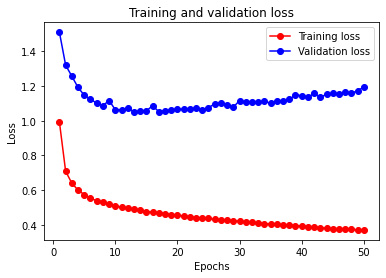

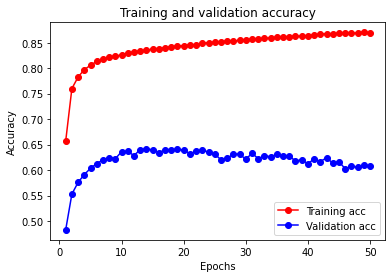

In [ ]:
# plot training and validation loss and acc

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", marker="o", label="Training loss")
plt.plot(epochs, val_loss_values, "b", marker="o",label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", marker="o", label="Training acc")
plt.plot(epochs, val_acc, "b", marker="o", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Retrain on the whole training dataset for 20 epochs

In [ ]:
# aggregrate the whole training data with the original clean MNIST dataset
X_train_agg_whole = np.vstack([train_images, train_images_clean, test_images_clean])
y_train_agg_whole = np.concatenate([train_labels, train_labels_clean, test_labels_clean])

print(X_train_agg_whole.shape)
print(y_train_agg_whole.shape)

(130000, 28, 28, 1)
(130000,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        # layers.Rescaling(scale=1./255),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        
        # maybe add some noises here as well
        # layers.GaussianNoise(1.0),
    ]
)


inputs = keras.Input(shape=(28, 28, 1))
# data augmentation
# x = data_augmentation(inputs)
x = inputs

x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
x = layers.Flatten()(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
              optimizer='adam',
              # optimizer=opt,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# test aggregated train and val data
history = model.fit(X_train_agg_whole, y_train_agg_whole, epochs=20, batch_size=256, shuffle=True)

Epoch 1/20
508/508 [==============================] - 15s 28ms/step - loss: 1.0377 - accuracy: 0.6407
Epoch 2/20
508/508 [==============================] - 14s 28ms/step - loss: 0.7405 - accuracy: 0.7471
Epoch 3/20
508/508 [==============================] - 14s 28ms/step - loss: 0.6674 - accuracy: 0.7734
Epoch 4/20
508/508 [==============================] - 14s 28ms/step - loss: 0.6270 - accuracy: 0.7868
Epoch 5/20
508/508 [==============================] - 14s 28ms/step - loss: 0.6019 - accuracy: 0.7967
Epoch 6/20
508/508 [==============================] - 14s 28ms/step - loss: 0.5822 - accuracy: 0.8021
Epoch 7/20
508/508 [==============================] - 14s 28ms/step - loss: 0.5649 - accuracy: 0.8084
Epoch 8/20
508/508 [==============================] - 14s 28ms/step - loss: 0.5571 - accuracy: 0.8115
Epoch 9/20
508/508 [==============================] - 14s 28ms/step - loss: 0.5450 - accuracy: 0.8134
Epoch 10/20
508/508 [==============================] - 14s 28ms/step - loss: 0.537

#### Save the Final Trained Model

In [ ]:
model.save('tianliu_525004380_project1_model_final.best')

INFO:tensorflow:Assets written to: tianliu_525004380_project1_model_final.best/assets


#### To test the trained model on the testing data

In [ ]:
# load the model
from tensorflow import keras

model = keras.models.load_model('tianliu_525004380_project1_model_final.best')

In [ ]:
# preprocess the testing data by reshaping and rescaling it, like the following:

test_images = pickle.load(open('636_project1_test_images', 'rb'))
test_labels = pickle.load(open('636_project1_test_labels', 'rb'))

test_images = np.array(test_images).reshape((60000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
test_labels = np.array(test_labels)

In [ ]:
# test the model
test_loss, test_acc = model.evaluate(test_images, test_labels)